In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

In [3]:
from src.scrape_wiki import PageviewsClient
import sys
sys.path.insert(0, 'src/') # solve annoying path issues (ModuleNotFoundError)
from src.update_keywords import read_keywords

In [4]:
import os
import json

Update the cell below such that it includes the keyword files you want to use. The only other thing you need to care about is to set the `language` variable (defined near the end of the notebook). The file patterns in the cell below will be formatted with the language. For instance, if you set `language='en'`, the file `'terrorism_{}.txt'` will be formatted to `'terrorism_en.txt'`. Currently, one cannot run this notebook in one shot to download data in several languages.

In [5]:
path_data = 'data/'
#keywords_terrorism = path_data + 'terrorism_{}.txt'
keywords_GDPR = path_data + 'GDPR_{}.txt'

keywords_lists = {
    'GDPR': keywords_GDPR
    #'terrorism': keywords_terrorism
}

# Introduction

## Prerequisites

Run the script `src/update_keywords.py` to generate lists of keywords, which you define in `keywords_lists` above.

## Scraping rules stated by Wikipedia

> * Limit your clients to no more than 200 requests/s to this API. Each API endpoint's documentation may detail more specific usage limits.
> * Set a unique `User-Agent` or `Api-User-Agent` header that allows us to contact you quickly. Email addresses or URLs of contact pages work well.

In [6]:
contact = 'matthias.zeller@epfl.ch'

## How is scraping performed here

We use existing Python packages:

* [python-mviews](https://github.com/mediawiki-utilities/python-mwviews), it conveniently handles requests to [Wikipedia REST API](https://wikimedia.org/api/rest_v1/). The `pageviews.py` files of the package was copied to `src/scrape_wiki.py`.

* [wikipedia](https://pypi.org/project/wikipedia/): search for articles and debug lowercase / uppercase

# Scraping

In [7]:
# Must provide email address (read the rules above)
p = PageviewsClient(contact)

## Settings

In [8]:
?PageviewsClient.article_views

Signature:
PageviewsClient.article_views(
    self,
    project,
    articles,
    access='all-access',
    agent='all-agents',
    granularity='daily',
    start=None,
    end=None,
)
Docstring:
Get pageview counts for one or more articles
See `<https://wikimedia.org/api/rest_v1/metrics/pageviews/?doc\
        #!/Pageviews_data/get_metrics_pageviews_per_article_project\
        _access_agent_article_granularity_start_end>`_
:Parameters:
    project : str
        a wikimedia project such as en.wikipedia or commons.wikimedia
    articles : list(str) or a simple str if asking for a single article
    access : str
        access method (desktop, mobile-web, mobile-app, or by default, all-access)
    agent : str
        user agent type (spider, user, bot, or by default, all-agents)
    end : str|date
        can be a datetime.date object or string in YYYYMMDD format
        default: today
    start : str|date
        can be a datetime.date object or string in YYYYMMDD format
        defaul

We specifically want to **retrieve pageviews of humans, so we must set `user="agent"`**.

In [9]:
params = {
    'agent': 'user',
    'start': '20150401', # 1st April 2015
    'end':   '20190531'  # 31th May 2019
}

In [10]:
def request(articles, domain='de', **kwargs):
    """Wraps the function PageviewsClient.article_views"""
    wrapped_kwargs = params.copy()
    wrapped_kwargs.update(kwargs)
    domain = domain + '.wikipedia'
    
    # Fetch
    res = p.article_views(articles=articles, project=domain, **wrapped_kwargs)
    
    # Format results in a DataFrame
    res = pd.DataFrame(res).T
    # Replace None -> np.nan
    res = res.applymap(lambda elem: np.nan if elem is None else elem)
    # Sort by dates
    res.sort_index(inplace=True)
    
    return res

## Sample request

In [11]:
sample = request(['Selfie', 'Cat', 'Dog'])
sample

,Selfie,Cat,Dog
2015-04-01,NaN,NaN,NaN
2015-04-02,NaN,NaN,NaN
2015-04-03,NaN,NaN,NaN
2015-04-04,NaN,NaN,NaN
2015-04-05,NaN,NaN,NaN
...,...,...,...
2019-05-27,117.0,10.0,9.0
2019-05-28,105.0,17.0,8.0
2019-05-29,85.0,12.0,12.0
2019-05-30,87.0,4.0,2.0


We get some annoying missing values 😑️. Let's see what is happening:

In [12]:
mask_missing = sample.isna().any(axis=1)
sample[mask_missing]

,Selfie,Cat,Dog
2015-04-01,NaN,NaN,NaN
2015-04-02,NaN,NaN,NaN
2015-04-03,NaN,NaN,NaN
2015-04-04,NaN,NaN,NaN
2015-04-05,NaN,NaN,NaN
...,...,...,...
2015-06-26,NaN,NaN,NaN
2015-06-27,NaN,NaN,NaN
2015-06-28,NaN,NaN,NaN
2015-06-29,NaN,NaN,NaN


This goes from 1st April 2015 to 30st June 2015. Let's check if changing granularity solves the problem:

In [13]:
monthly = request(['Selfie', 'Cat', 'Dog'], granularity='monthly')
monthly.head()

,Selfie,Cat,Dog
2015-04-01,NaN,NaN,NaN
2015-05-01,NaN,NaN,NaN
2015-06-01,NaN,NaN,NaN
2015-07-01,12205.0,439.0,416.0
2015-08-01,9789.0,400.0,434.0


This does not solve the problem 😪️. Before trying to solve the problem, it's an occasion to check if daily and monthly data match:

In [14]:
# Aggregate daily data to monthly sum of views
sample_aggreg = sample.groupby(pd.Grouper(freq='M')).sum()

# The default DateTimeIndex generated when grouping data by months
# contains as days the last day of month (e.g. 31)
# We make those dates match the dates of the downloaded monthly data
sample_aggreg.index = map(lambda date: date.replace(day=1), sample_aggreg.index)

mask_not_na = (~monthly.isna().any(axis=1))

print(f'All elements are equal: {np.all(sample_aggreg[mask_not_na] == monthly[mask_not_na])}')

All elements are equal: True


**Conclusion**: after some reasearch, data is not available before July 2015 with this new API.

## Scrape keywords

In [15]:
language = 'de'
# Load keywords lists as defined in keywords_lists (defined on top of this notebook)
keywords = {}
for listname, filename in keywords_lists.items():
    keywords[listname] = read_keywords(filename.format(language))

In [16]:
keywords

{'GDPR': ['Verschwiegenheitspflicht',
  'Cyber-Terrorismus',
  'Daten',
  'Richtlinie 95/46/EG (Datenschutzrichtlinie)',
  'Erhebung (Empirie)',
  'Datenschutz-Grundverordnung',
  'Datenschutz',
  'Informationssicherheit',
  'Personenbezogene Daten',
  'Privatsphäre',
  'Datenschutzrecht',
  'Anonymisierung und Pseudonymisierung',
  'Transparenz (Politik)',
  'Zensur im Internet',
  'Internet Privacy Act',
  'Informationsmanagement',
  'Business Intelligence',
  'Langzeitarchivierung',
  'Datenschutz-Grundverordnung',
  'Vorratsdatenspeicherung',
  'Datenvernichtung',
  'Digitale Rechteverwaltung',
  'Digitale Rechte',
  'Datenschutzerklärung',
  'Datenanalyse',
  'Datenmanagement',
  'Informationsintegration',
  'Anonymität',
  'Persönliche Identifikationsnummer',
  'Big Data',
  'Rechtsinformatik',
  'Internet Governance',
  'Automatische Identifikation und Datenerfassung',
  'Online-Durchsuchung',
  'Gläserner Mensch (Datenschutz)',
  'Europäische Kommission',
  'Verordnung (EU)',
 

Reminder: we use the custom function `request`:

In [17]:
help(request)

Help on function request in module __main__:

request(articles, domain='de', **kwargs)
    Wraps the function PageviewsClient.article_views



In [18]:
# Redefine params
params = {
    'agent': 'user',
    'start': '20150401', # 1st April 2015
    'end':   '20190531'  # 31th May 2019
}

In [19]:
data = {
    listname: request(kwlist, language)
    for listname, kwlist in keywords.items()
}

In [20]:
def format_dataset(df, language):
    out = pd.DataFrame(df.unstack()).reset_index()
    out.columns = ['article', 'date', 'views']
    out['language'] = language
    return out

In [21]:
data['GDPR']

,Verschwiegenheitspflicht,Cyber-Terrorismus,Daten,Richtlinie_95/46/EG_(Datenschutzrichtlinie),Erhebung_(Empirie),Datenschutz-Grundverordnung,Datenschutz,Informationssicherheit,Personenbezogene_Daten,Privatsphäre,...,Big_Data,Rechtsinformatik,Internet_Governance,Automatische_Identifikation_und_Datenerfassung,Online-Durchsuchung,Gläserner_Mensch_(Datenschutz),Europäische_Kommission,Verordnung_(EU),Individualrecht,HTTP-Cookie
2015-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-27,279.0,10.0,207.0,66.0,40.0,1888.0,499.0,342.0,272.0,141.0,...,541.0,6.0,4.0,32.0,51.0,45.0,4494.0,243.0,13.0,678.0
2019-05-28,343.0,4.0,164.0,51.0,34.0,1840.0,467.0,395.0,253.0,115.0,...,539.0,13.0,5.0,28.0,42.0,59.0,3974.0,261.0,14.0,667.0
2019-05-29,303.0,9.0,161.0,43.0,35.0,1496.0,442.0,537.0,201.0,131.0,...,473.0,5.0,12.0,41.0,107.0,45.0,2721.0,201.0,11.0,597.0
2019-05-30,168.0,5.0,103.0,33.0,20.0,898.0,170.0,130.0,106.0,104.0,...,288.0,10.0,6.0,13.0,61.0,25.0,1244.0,100.0,5.0,487.0


In [22]:
# Pivot / unstack dataframes
data = {
    listname: format_dataset(df, language)
    for listname, df in data.items()
}

In [23]:
data['GDPR']

,article,date,views,language
0,Verschwiegenheitspflicht,2015-04-01,NaN,de
1,Verschwiegenheitspflicht,2015-04-02,NaN,de
2,Verschwiegenheitspflicht,2015-04-03,NaN,de
3,Verschwiegenheitspflicht,2015-04-04,NaN,de
4,Verschwiegenheitspflicht,2015-04-05,NaN,de
...,...,...,...,...
57831,HTTP-Cookie,2019-05-27,678.0,de
57832,HTTP-Cookie,2019-05-28,667.0,de
57833,HTTP-Cookie,2019-05-29,597.0,de
57834,HTTP-Cookie,2019-05-30,487.0,de


In [24]:
# Write data in files
for listname, df in data.items():
    fname = path_data + listname + f'_{language}.csv'
    df.to_csv(fname, index=False)

# Visualize 

In [26]:
import math

def pageviews_small_multiples(df_longitudinal, n_col=5, yscale='log', rolling_window=None):
    """
    :param pandas.DataFrame df_longitudinal: 
    :param int n_col: number of columns for the plot, number of rows are automatically deduced
    :param str yscale: log or linear, passed to ax.set_yscale
    :param int rolling_window: size of the mean rolling window, units depends on dates in df_longitudinal
    """
    if df_longitudinal.language.nunique() > 1:
        raise ValueError
        
    articles = df_longitudinal.article.unique()
    if 'date' in df_longitudinal.columns:
        df_longitudinal = df_longitudinal.set_index('date')
    if yscale == 'log':
        df_longitudinal = df_longitudinal.replace(0, np.nan)
    
    # Init plotting
    colors = sns.color_palette(n_colors=len(articles))
    n_row = math.ceil(len(articles) / n_col)
    fig, axes = plt.subplots(n_row, n_col, figsize=(4*n_col + .5, 2*n_row + .5), sharex=True, sharey=True)
    
    # Plotting loop
    for article, ax, col in zip(articles, axes.ravel(), colors):
        # Extract article data
        subdf = df_longitudinal[df_longitudinal.article == article].copy()
        # Smooth data
        if rolling_window is not None:
            subdf.views = subdf.views.rolling(rolling_window).mean()
        # Plot
        subdf.plot(y='views', ax=ax, legend=False, color=col)
        ax.set_title(article)
        ax.set_yscale(yscale)
        
    # Aesthetics
    for ax in axes[-1]:
        ax.set_xlabel('Date')
    for ax in axes[:, 0]:
        ax.set_ylabel('Views')
        
    plt.tight_layout()

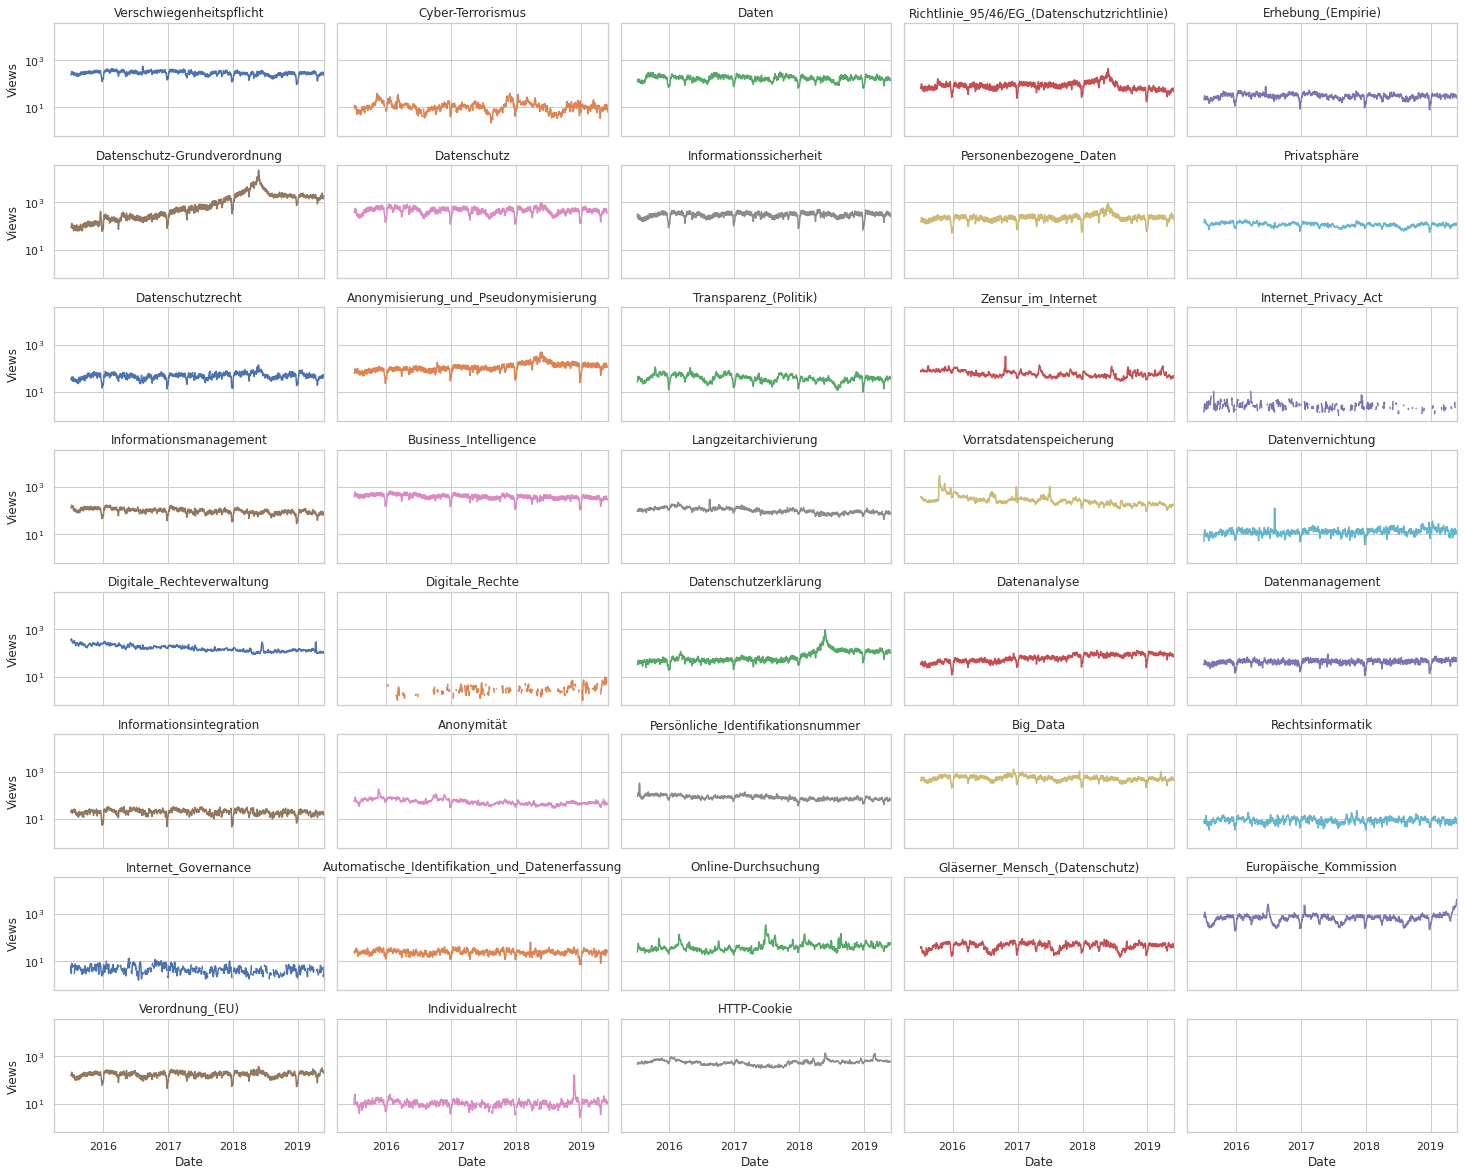

In [27]:
pageviews_small_multiples(data['GDPR'], rolling_window=5)

# Top articles

We select the top articles with following rationale:

1. Fetch the monthly top 1000 articles for every date specified
1. Retain the articles that appear in top articles of all dates
1. Compute the sum across all dates and sort the articles
1. Select the first $N$ articles in this sorted list

We could also do (1), then sum and sort, then select. 

In [28]:
?PageviewsClient.top_articles

Signature:
PageviewsClient.top_articles(
    self,
    project,
    access='all-access',
    year=None,
    month=None,
    day=None,
    limit=1000,
)
Docstring:
Get pageview counts for one or more articles
See `<https://wikimedia.org/api/rest_v1/metrics/pageviews/?doc\
        #!/Pageviews_data/get_metrics_pageviews_top_project\
        _access_year_month_day>`_
:Parameters:
    project : str
        a wikimedia project such as en.wikipedia or commons.wikimedia
    access : str
        access method (desktop, mobile-web, mobile-app, or by default, all-access)
    year : int
        default : yesterday's year
    month : int
        default : yesterday's month
    day : int
        default : yesterday's day
    limit : int
        limit the number of articles returned to only the top <limit>
        default : 1000
:Returns:
    a sorted list of articles that looks like: [
        {
            rank: <int>,
            article: <str>,
            views: <int>
        }
        ...
    

In [29]:
def request_top(dates, domain='de', limit=500):
    """Wraps the function PageviewsClient.top_articles"""
    domain = domain + '.wikipedia'
    
    # Fetch
    res = []
    for d in dates:
        try:
            tmp = p.top_articles(domain, **d, limit=limit)
        except Exception:
            continue
        tmp = pd.DataFrame(tmp)
        tmp['year'] = d['year']
        tmp['month'] = d['month']
        res.append(tmp)
    
    # Format results in a DataFrame
    res = pd.concat(res, ignore_index=True)
    # Replace None -> np.nan
    res = res.applymap(lambda elem: np.nan if elem is None else elem)
    
    res['language'] = domain.split('.')[0]
    
    return res

In [30]:
dates = [
    {'year': year, 'month': month, 'day': 'all-days'}
    for year in [2015, 2016, 2017, 2018, 2019]
    for month in range(1, 13)
]

top = request_top(dates, limit=400)

In [31]:
top.groupby(['year', 'month']).article.nunique().unique()

array([400])

We indeed have 1000 articles for each month.

We find the intersection of articles for all dates:

In [32]:
intersect = set(top.article.unique())
for i, a in top.groupby(['year', 'month']).article:
    intersect = intersect.intersection(a)
    
intersect = list(intersect)

In [33]:
print(intersect)

['Polen', 'Adolf_Hitler', 'Schweiz', 'Angela_Merkel', 'Wien', 'Game_of_Thrones', 'Berlin', 'Türkei', 'Italien', 'Japan', 'Special:Search', 'Frankreich', 'Wikipedia:Hauptseite', 'Bayern', 'Niederlande', 'Liste_der_Kfz-Kennzeichen_in_Deutschland', 'Vereinigtes_Königreich', 'Wikipedia', 'Verwandtschaftsbeziehung', 'Vereinigte_Staaten', 'Österreich', 'Europäische_Union', 'Hamburg', 'Datei:Germany_adm_location_map.svg', 'Napoleon_Bonaparte', 'Spezial:Beobachtungsliste', 'Benutzer:Plenz/OSM_for_Wiki/languages', 'Hauptseite', 'Russland', 'Volksrepublik_China', 'Periodensystem', 'Vagina', 'New_York_City', 'Indien', 'Liste_der_IPA-Zeichen', 'Spezial:Search', 'Europa', 'München', 'Kanada', 'Nordrhein-Westfalen', 'Figuren_aus_dem_Marvel-Universum', 'Australien', 'Erster_Weltkrieg', 'Deutschland', 'Wikipedia:Vandalismusmeldung', 'Asperger-Syndrom', 'Spezial:Letzte_Änderungen', 'Spezial:Suche', 'Zweiter_Weltkrieg']


In [34]:
# Keep only "real" articles
specials = [
    'Spezial:', 'Wikipedia:', 'Datei:', 'Benutzer:', 'Special:', 'Hauptseite'
]

selection = [
    e for e in intersect if not any(map(lambda special: special in e, specials))
]

print(len(selection))
sorted(selection)

39


['Adolf_Hitler',
 'Angela_Merkel',
 'Asperger-Syndrom',
 'Australien',
 'Bayern',
 'Berlin',
 'Deutschland',
 'Erster_Weltkrieg',
 'Europa',
 'Europäische_Union',
 'Figuren_aus_dem_Marvel-Universum',
 'Frankreich',
 'Game_of_Thrones',
 'Hamburg',
 'Indien',
 'Italien',
 'Japan',
 'Kanada',
 'Liste_der_IPA-Zeichen',
 'Liste_der_Kfz-Kennzeichen_in_Deutschland',
 'München',
 'Napoleon_Bonaparte',
 'New_York_City',
 'Niederlande',
 'Nordrhein-Westfalen',
 'Periodensystem',
 'Polen',
 'Russland',
 'Schweiz',
 'Türkei',
 'Vagina',
 'Vereinigte_Staaten',
 'Vereinigtes_Königreich',
 'Verwandtschaftsbeziehung',
 'Volksrepublik_China',
 'Wien',
 'Wikipedia',
 'Zweiter_Weltkrieg',
 'Österreich']

This is consistent, the first 6 dates are not available so if Neuseeland appears 54 times, it's a top article in all available dates.

We format the control dataset to save it in the same format as our study data:

In [35]:
ctrl = top[top.article.isin(selection)].copy()
ctrl['date'] = list(map(lambda tpl: f'{tpl[0]}-{tpl[1]}', zip(ctrl.year, ctrl.month)))
ctrl.date = pd.to_datetime(ctrl.date)

ctrl = ctrl[['article', 'views', 'date', 'language']]

ctrl

,article,views,date,language
13,Deutschland,477014,2015-07-01,de
17,Game_of_Thrones,360283,2015-07-01,de
37,Wikipedia,194898,2015-07-01,de
38,Vereinigte_Staaten,192909,2015-07-01,de
50,Schweiz,169767,2015-07-01,de
...,...,...,...,...
21527,Türkei,77075,2019-12-01,de
21540,Napoleon_Bonaparte,75683,2019-12-01,de
21556,Bayern,74515,2019-12-01,de
21582,Nordrhein-Westfalen,71741,2019-12-01,de


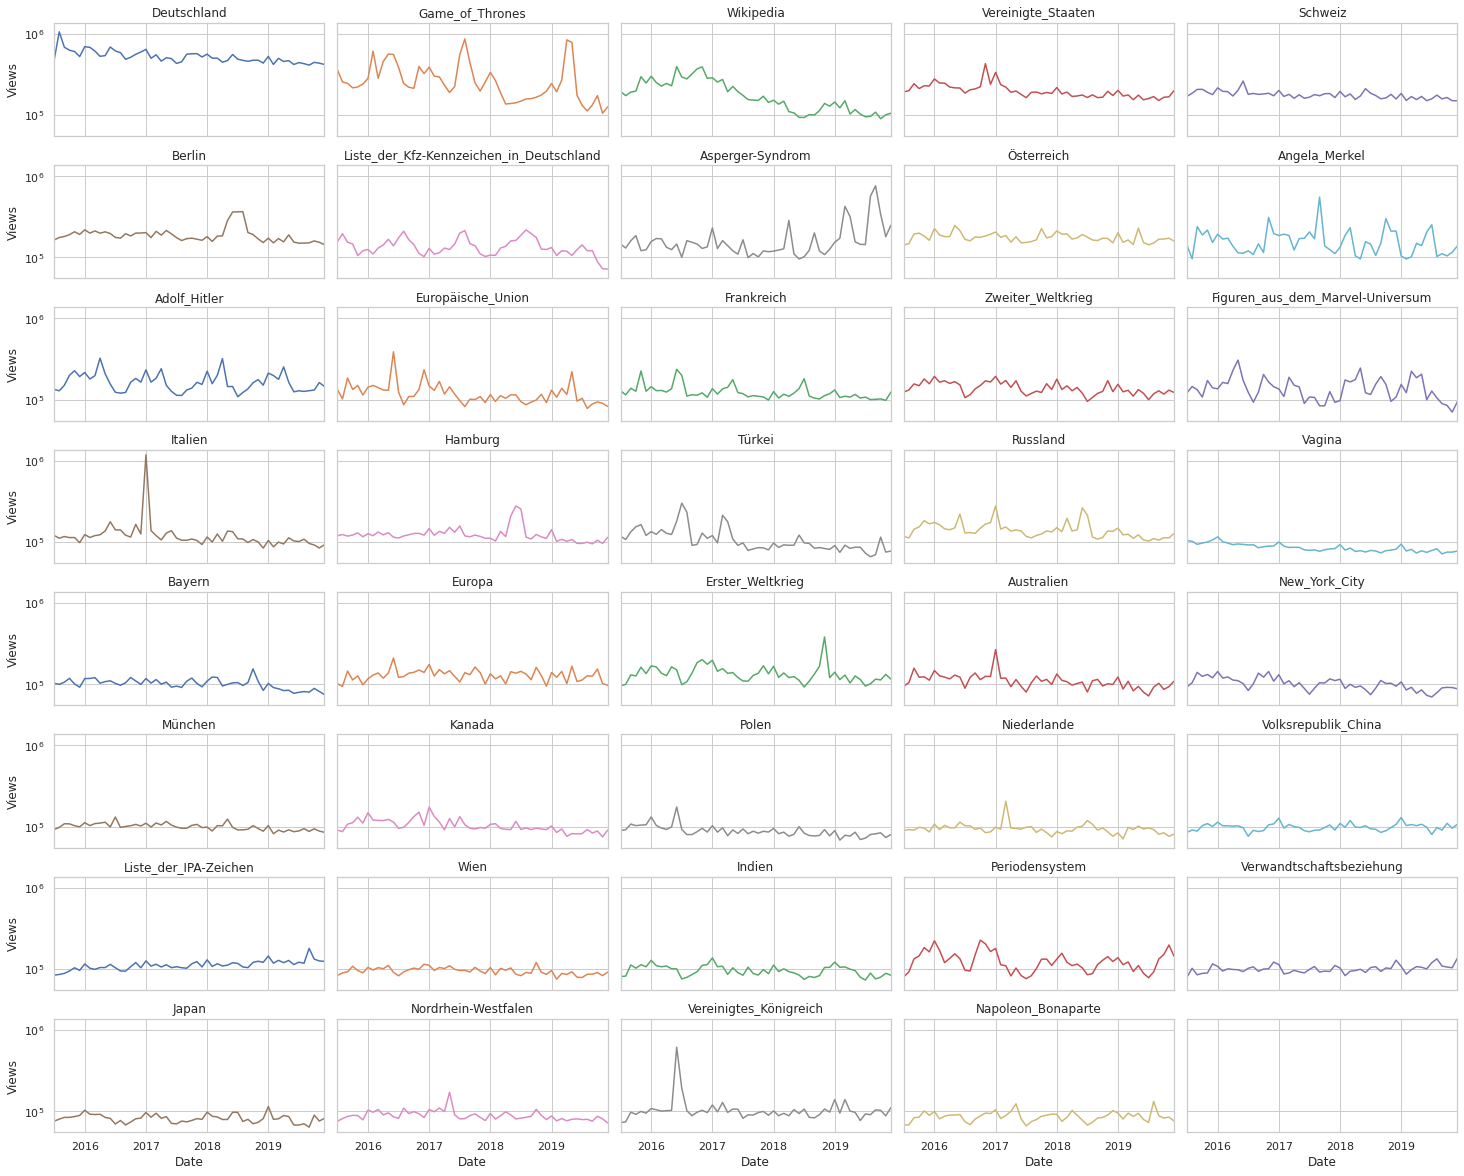

In [36]:
pageviews_small_multiples(ctrl)

In [37]:
ctrl.to_csv('data/top_articles_de.csv', index=False)